In [4]:
# !pip install scikit-optimize

# Gaussian Process Regression Metamodel

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV

In [6]:
file_path = "Concrete_Strength_Data.csv"
concrete_data = pd.read_csv(file_path)

y_initial = concrete_data['Strength']
y_initial = np.array(y_initial)

concrete_data = concrete_data.drop(columns=['Strength'])

x_initial = np.zeros_like(concrete_data)
x_val_list = []
for i in range(0, len(concrete_data), 1):
  x_val = concrete_data.iloc[i]
  x_val_list.append(x_val)
x_val_array = np.array(x_val_list)
x_initial = x_val_array
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cement                     1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 64.5 KB


In [7]:
scaler = StandardScaler()
x_initial_scaled = scaler.fit_transform(x_initial)

x_train, x_test, y_train, y_test = train_test_split(x_initial_scaled,
                                                    y_initial,
                                                    test_size=.2,
                                                    random_state=42)

In [13]:
base_kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=10.0,
                                   length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level = 1,
                                                                                  noise_level_bounds = (1e-3, 1e2))
gpr_model = GaussianProcessRegressor(kernel = base_kernel,
                                     alpha = 0.0,
                                     n_restarts_optimizer = 5,
                                     random_state = 42)

param_distributions = {
    "kernel":[
        C(constant_value = 1.0,
          constant_value_bounds = (1e-2, 1e2)) *
        RBF(length_scale = 1.0,
            length_scale_bounds = (1e-2, 1e3)) +
        WhiteKernel(noise_level = 1.0,
                    noise_level_bounds = (1e-3, 1e2))
    ]
}

num_samples = 50
kernel_candidates = []
for _ in range(num_samples):

  constant_value_sample = loguniform.rvs(1e-2, 1e2)
  length_scale_sample = loguniform.rvs(1e-2, 1e2)
  noise_level_sample = loguniform.rvs(1e-3, 1e1)

  k = C(constant_value = constant_value_sample) * RBF(length_scale = length_scale_sample) + WhiteKernel(noise_level = noise_level_sample)
  kernel_candidates.append(k)

param_distributions = {
    "kernel" : kernel_candidates
}

In [14]:
random_search = RandomizedSearchCV(
    estimator = gpr_model,
    param_distributions = param_distributions,
    n_iter = 50,
    cv = 5,
    scoring = 'r2',
    n_jobs = -1,
    random_state = 42,
    verbose = 2
)
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=GaussianProcessRegressor(alpha=0.0,
                                                      kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=1),
                                                      n_restarts_optimizer=5,
                                                      random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'kernel': [3.75**2 * RBF(length_scale=20.5) + WhiteKernel(noise_level=1.24),
                                                   1.9**2 * RBF(length_scale=0.602) + WhiteKernel(noise_level=0.00155),
                                                   0.31*...
                                                   0.689**2 * RBF(length_scale=4.43) + WhiteKernel(noise_level=0.00128),
                                                   0.946**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.06),
                                                   1.33**2 * RBF(length_scale=1.26) + WhiteKernel(noise_level=0.00509),
                                                   0.5**2 * RBF(length_scale=6.52) + WhiteKernel(noise_level=0.643),
                                                   0.129**2 * RBF(length_scale=1.05) + WhiteKernel(noise_level=1.82), ...]},
                   random_state=42, scoring='r2', verbose=2)

In [16]:
best_gpr = random_search.best_estimator_
# best_gpr = GaussianProcessRegressor(alpha=0.0,
#                          kernel=0.693**2 * RBF(length_scale=5.11) + WhiteKernel(noise_level=0.0266),
#                          n_restarts_optimizer=5, random_state=42)

y_pred, y_std = best_gpr.predict(x_test, return_std=True)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE with best parameters:", mse)
print("Test R² with best parameters:", r2)

Test MSE with best parameters: 32.430356812564725
Test R² with best parameters: 0.8741433263052141


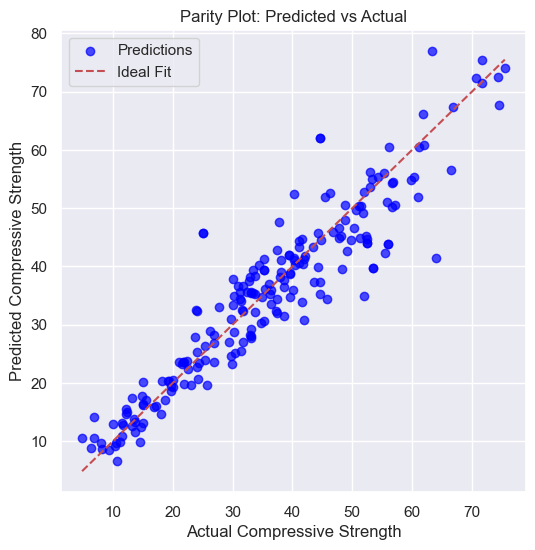

In [17]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title('Parity Plot: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()